## CA3

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say **`YOUR CODE HERE`**.

- You will need to use GPU, which can be added through
`Edit > Notebook Settings > Hardware accelerator > (GPU)`

- For text-based answers, you should replace the text that says **`Write your answer here...`** with your actual answer.

- This assignment is designed such that each cell takes a few minutes (if that) to run. If it is taking longer than that, you might have made a mistake in your code.

---

##### *How to submit this problem set:*
- Write all the answers in this Colab notebook. Once you are finished, generate a PDF via (File -> Print -> Save as PDF) and upload it to Gradescope.
  
- **Important:** check your PDF before you submit to Gradescope to make sure it exported correctly. If Colab gets confused about your syntax, it will sometimes terminate the PDF creation routine early.

- When creating your final version of the PDF to hand in, please do a fresh restart and execute every cell in order. One handy way to do this is by clicking `Runtime -> Run All` in the notebook menu.

# Part 0: Setup

## Installing Hugging Face's Transformers and Additional Libraries
We will use Hugging Face's Transformers (https://github.com/huggingface/transformers), an open-source library that provides general-purpose architectures for natural language understanding and generation with a collection of various pretrained models made by the NLP community. This library will allow us to easily use pretrained models like `BERT` and perform experiments on top of them. We can use these models to solve downstream target tasks, such as text classification, question answering, sequence labeling, and text generation.

Run the following cell to install Hugging Face's Transformers library and some other useful tools. This cell will also download data used later in the assignment.

In [ ]:
!pip3 install -U accelerate
!pip install -q -U transformers==4.17.0 datasets==2.0.0 rich[jupyter]
!pip3 install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.5/325.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=9334d57a66c3cb5c2d94a6155093bb02df559f05d825000d3da708b21e60c001
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


## Import Necessary Libraries

In [ ]:
import torch
from torch.utils.data import (
    Dataset, DataLoader
)
from transformers import (
    GPT2LMHeadModel, GPT2Tokenizer,
    BartTokenizerFast, BartForConditionalGeneration,
    TrainingArguments, Trainer
)
from transformers.optimization import AdamW
from datasets import (
    load_dataset, load_metric
)

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from tqdm import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Part 1. Beam Search
We're going to explore decoding from a pretrained GPT-2 model using beam search. Run the below cell to set up some beam search utilities.

In [ ]:
def init_beam_search(model, input_ids, num_beams):
    assert len(input_ids.shape) == 2
    beam_scores = torch.zeros(num_beams, dtype=torch.float32, device=model.device)
    beam_scores[1:] = -1e9 # Break ties in first round.
    new_input_ids = input_ids.repeat_interleave(num_beams, dim=0).to(model.device)
    return new_input_ids, beam_scores

# i added "n=[]" to the parameters list of the "run_beam_search_" method:
def run_beam_search_(model, tokenizer, input_text, num_beams=5, num_decode_steps=10, score_processors=[], n=[], to_cpu=True):

    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    input_ids, beam_scores = init_beam_search(model, input_ids, num_beams)
    token_scores = beam_scores.clone().view(num_beams, 1)

    model_kwargs = {}
    for i in range(num_decode_steps):
        model_inputs = model.prepare_inputs_for_generation(input_ids, **model_kwargs)
        outputs = model(**model_inputs, return_dict=True)
        next_token_logits = outputs.logits[:, -1, :]
        vocab_size = next_token_logits.shape[-1]
        this_token_scores = torch.log_softmax(next_token_logits, -1)

        # Process token scores.
        processed_token_scores = this_token_scores
        for processor in score_processors:
            processed_token_scores = processor(input_ids, processed_token_scores, n) # i added "n" to the arguments

        # Update beam scores.
        next_token_scores = processed_token_scores + beam_scores.unsqueeze(-1)
        next_token_scores = next_token_scores.view(num_beams * vocab_size)

        # Find top-scoring beams.
        next_token_scores, next_tokens = torch.topk(
            next_token_scores, num_beams, dim=0, largest=True, sorted=True
        )

        # Transform tokens since we reshaped earlier.
        next_indices = torch.div(next_tokens, vocab_size, rounding_mode="floor") # This is equivalent to `next_tokens // vocab_size`
        next_tokens = next_tokens % vocab_size

        # Update tokens and beam scores.
        input_ids = torch.cat([input_ids[next_indices, :], next_tokens.unsqueeze(-1)], dim=-1)
        beam_scores = next_token_scores

        # UNCOMMENT: To use original scores instead.
        # token_scores = torch.cat([token_scores[next_indices, :], this_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)
        token_scores = torch.cat([token_scores[next_indices, :], processed_token_scores[next_indices, next_tokens].unsqueeze(-1)], dim=-1)

        # Update hidden state.
        model_kwargs = model._update_model_kwargs_for_generation(outputs, model_kwargs, is_encoder_decoder=False)
        model_kwargs["past"] = model._reorder_cache(model_kwargs["past"], next_indices)

    def transfer(x):
      return x.cpu() if to_cpu else x

    return {
        "output_ids": transfer(input_ids),
        "beam_scores": transfer(beam_scores),
        "token_scores": transfer(token_scores)
    }


def run_beam_search(*args, **kwargs):
    with torch.inference_mode():
        return run_beam_search_(*args, **kwargs)

Run the cell below. It produces a sequence of tokens using beam search and the provided prefix.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

num_beams = 5
num_decode_steps = 10
input_text = 'The brown fox jumps'

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=num_decode_steps)
for i, tokens in enumerate(beam_output['output_ids']):
    score = beam_output['beam_scores'][i]
    print(i, round(score.item() / tokens.shape[-1], 3), tokenizer.decode(tokens, skip_special_tokens=True))

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

0 -1.106 The brown fox jumps out of the fox's mouth, and the fox
1 -1.168 The brown fox jumps out of the fox's cage, and the fox
2 -1.182 The brown fox jumps out of the fox's mouth and starts to run
3 -1.192 The brown fox jumps out of the fox's mouth and begins to lick
4 -1.199 The brown fox jumps out of the fox's mouth and begins to bite


## Question 1.1

Write a code to investigate the probabilities that the model assigns to each generated word using beam size one (you can use visualizations or simply report the results).
Do the probabilities increase or decrease while more words are generated? Can you explain the reason?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

In the results I got for this question (which is better shown in the plot), the probabilities of generating words or tokens tend to decrease as more words are generated or predicted, due to the nature of language modeling and also probability. The conditional probability distribution of words given the context words (the words the algorithm has generated thus far) becomes more specific and constraining as the sequence grows longer and more words are added. I know that each beam in beam search algorithm represents a different possible continuation or path. Through each path, the algorithm becomes more certain about next probable words based on the expanding context, leading to a decrease in probability values. However, it is worth mentioning that this behavior is not universal and can in fact vary depending on factors such as language model characteristics and training data.

Generated sequence: The brown fox jumps up and down on the ground, and then he




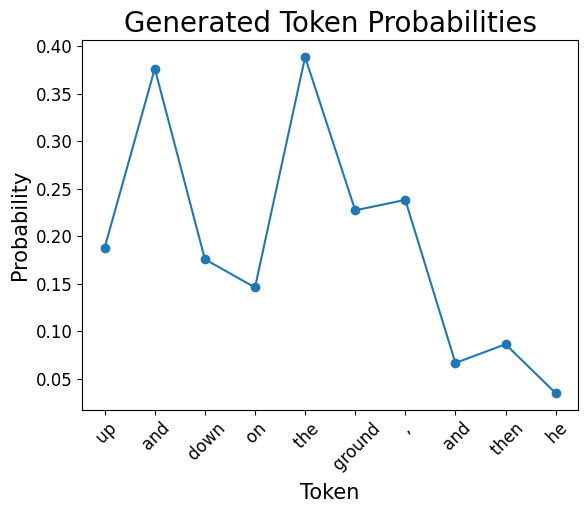

In [ ]:
import matplotlib.pyplot as plt

def generated_word_probability():
    # WRITE YOUR CODE HERE!

    beam_output = run_beam_search(model, tokenizer, input_text, num_beams=1, num_decode_steps=num_decode_steps, to_cpu=True)

    # we first display the generated sentence:

    output_ids = beam_output["output_ids"][0]

    decoded_tokens = tokenizer.decode(output_ids, skip_special_tokens=True)
    print(f"Generated sequence: {decoded_tokens}\n\n")

    # then, we calculate the probabilities:

    probs = beam_output["token_scores"][0, 1:].exp()
    output_subwords = [tokenizer.decode(token, skip_special_tokens=True) for token in beam_output["output_ids"][0]]

    plt.plot(range(len(probs)), probs, marker="o")

    plt.xticks(range(len(probs)), output_subwords[-len(probs):], fontsize=12, rotation=45)
    plt.yticks(fontsize=12)

    plt.xlabel("Token", fontsize=15)
    plt.ylabel("Probability", fontsize=15)

    plt.title("Generated Token Probabilities", fontsize=20)

    plt.show()

generated_word_probability()

## Question 1.2

Use higher beam size and compute the cumulative probability of each different sequence and report the results. Does a higher beam size always guarantee a higher probability for the final sequence? Why or why not?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***


In beam search for natural language processing, I think that using a higher beam size does not guarantee a higher probability for the final predicted or generated sequence of words. I already know that the beam size determines how many candidate sequences are considered at each step. This fact leads to keeping a balance exploration and exploitation of the algorithm. While a higher beam size explores more diverse possibilities and may encounter words or toknes never seen before, it may also lead to lower overall sequence probability due to factors such as early mistakes, a larger search space, and increased computational cost. Just like any hyperparameter in deep neural networks, the optimal beam size depends on the specific task and requires multiple experimentations and trial-and-error.

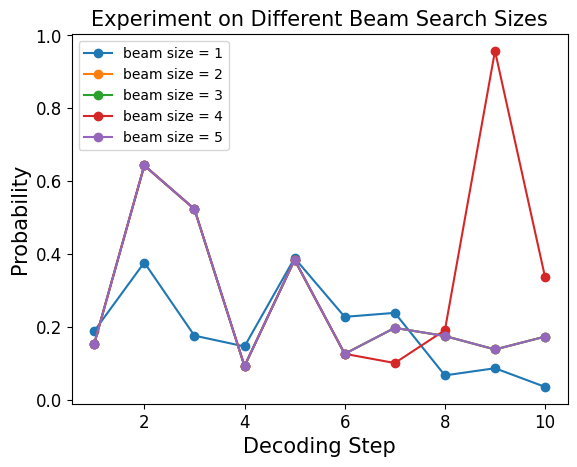


Model Predictions/Generations:

 ****************

Beam Size = 1

Generated Sequence:
The brown fox jumps up and down on the ground, and then he

Beam Scores = -1.334479604448591

 ****************

Beam Size = 2

Generated Sequence:
The brown fox jumps out of the fox's mouth, and the fox

Beam Scores = -1.106057916368757

 ****************

Beam Size = 3

Generated Sequence:
The brown fox jumps out of the fox's mouth, and the fox

Beam Scores = -1.1060577120099748

 ****************

Beam Size = 4

Generated Sequence:
The brown fox jumps out of the fox's mouth.

"

Beam Scores = -0.9620916502816337

 ****************

Beam Size = 5

Generated Sequence:
The brown fox jumps out of the fox's mouth, and the fox

Beam Scores = -1.1060571670532227


In [ ]:
def generated_sequence_probability():
    # WRITE YOUR CODE HERE!

    beam_sizes = [1, 2, 3, 4, 5]

    outputs_list = []
    probs_list = []

    for beam_size in beam_sizes:
        beam_output = run_beam_search(model, tokenizer, input_text, num_beams=beam_size, num_decode_steps=num_decode_steps)
        outputs_list.append(beam_output)

        probs = beam_output["token_scores"][0, 1:].exp()
        probs_list.append((beam_size, probs))

    # probs_list[index][0]: beam_size || probs_list[index][1]: probs

    plt.plot(range(1, len(probs) + 1), probs_list[0][1], label=f'beam size = {probs_list[0][0]}', marker="o")
    plt.plot(range(1, len(probs) + 1), probs_list[1][1], label=f'beam size = {probs_list[1][0]}', marker="o")
    plt.plot(range(1, len(probs) + 1), probs_list[2][1], label=f'beam size = {probs_list[2][0]}', marker="o")
    plt.plot(range(1, len(probs) + 1), probs_list[3][1], label=f'beam size = {probs_list[3][0]}', marker="o")
    plt.plot(range(1, len(probs) + 1), probs_list[4][1], label=f'beam size = {probs_list[4][0]}', marker="o")

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.xlabel("Decoding Step", fontsize=15)
    plt.ylabel("Probability", fontsize=15)

    plt.legend(loc="best", fontsize=10)

    plt.title("Experiment on Different Beam Search Sizes", fontsize=15)

    plt.show()

    """
    beam sizes 2, 3 and 5 overlap!
    """

    print("\nModel Predictions/Generations:")

    for beam_size, beam_output in zip(beam_sizes, outputs_list):
        print("\n", "*" * 16)

        print("\nBeam Size =", beam_size)

        tokens = beam_output["output_ids"][0]

        print("\nGenerated Sequence:")
        print(tokenizer.decode(tokens, skip_special_tokens=True))

        print("\nBeam Scores =", beam_output["beam_scores"][0].item() / tokens.shape[-1])

generated_sequence_probability()

## Question 1.3

Beam search often results in repetition in the predicted tokens. One way to prevent such repetitions is a technique called `Word Block`. At each time step, it reduces the probability for any previously seen word so that it is not generated again. What is the problem with this approach?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

Of the drawbacks of this approach, I can name the potential loss of coherence in generated sequences, limited vocabulary diversity, dependency on beam width, difficulty in learning long-term dependencies, increased training complexity, and sensitivity to hyperparameters. When we apply Word Block, keeping a balance between preventing repetition and maintaining natural language flow is really important.

Also, I talk about each of the drawbacks in detail, which as follows:

* Loss of Coherence: Suppressing the probability of generating previously seen words may hinder the model's coherence, leading to sentences lacking fluency and natural flow.
*Limited Vocabulary Diversity: Word Block constrains the model's word reuse, limiting sequence diversity and potentially resulting in outputs lacking richness and varied vocabulary.
* Dependency on Beam Width: Word Block's effectiveness depends on the chosen beam width during beam search, requiring non-trivial tuning that may vary with different beam sizes.
* Difficulty in Learning Long-Term Dependencies: Word Block faces challenges in capturing long-term dependencies, as blocking repetition could hinder the model's ability to understand certain contexts.
* Increased Training Difficulty: Training a model with Word Block is more challenging due to added complexity from constraining previously generated words, necessitating careful hyperparameter tuning and a sophisticated training strategy.
* Sensitivity to Hyperparameters: Word Block's performance is sensitive to hyperparameter choices, including the strength of the blocking mechanism, requiring a delicate balance to prevent repetition without sacrificing coherence.

## Question 1.4

Write a score processor called `BeamBlock`. This processor should prevent n-grams from appearing more than once in the sequence. Obviously, n should be an input argument. pass your score processesor to the `score_processors` argument of the `run_beam_search_` function.
Compare the result of generated sentences for `n = 1, 2, and 3` by running a beam search with beam size 1 for the following input text:

`input_text = 'Once upon a time, in a barn near a farm house,'`


In [ ]:
class BeamBlock:
    def __call__(self, input_ids, scores, n):
        for batch_idx in range(input_ids.shape[0]):
            # WRITE YOUR CODE HERE!

            sequence = input_ids[batch_idx].tolist()

            if len(sequence) > n:
                for i in range(len(sequence) - n):
                    if sequence[-n:] == sequence[i: i + n]:
                        scores[batch_idx, :] = -1e16

        return scores

input_text = "Once upon a time, in a barn near a farm house,"

num_beams = 1

print("\nBeam Search without using BeamBlock module:")

beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[])
print(tokenizer.decode(beam_output["output_ids"][0], skip_special_tokens=True))

print("\nBeam Search with Beam Block")

for n in [1, 2, 3]:
    print("\nn =", n)

    # we have to modify the "run_beam_search" in a way that it uses "n" parameter:
    beam_output = run_beam_search(model, tokenizer, input_text, num_beams=num_beams, num_decode_steps=40, score_processors=[BeamBlock()], n=n)

    print(tokenizer.decode(beam_output["output_ids"][0], skip_special_tokens=True))


Beam Search without using BeamBlock module:
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with a stick, and the boy was playing with a stick. The boy was playing with a stick, and the boy was playing with a

Beam Search with Beam Block

n = 1
Once upon a time, in a barn near a farm house,!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

n = 2
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing!!!!!!!!!!!!!!!!!!!!!!!!!!!!

n = 3
Once upon a time, in a barn near a farm house, a young boy was playing with a stick. He was playing with!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [ ]:
del model
del tokenizer

# Part 2. Language Model Fine-tuning
Now, we'll switch over to *fine-tuning* a pretrained language model. For this task, we'll use data from the `CNN Dailymail Dataset` Available [here](https://huggingface.co/datasets/cnn_dailymail). The CNN DailyMail Dataset is an English dataset containing just over 300k unique news articles as written by journalists at CNN and the Daily Mail and can be used to train a model for abstractive and extractive summarization.

We are going to get familiar with coding frameworks to use or fine-tune pre-trained models. In some sections, you need to complete the codes in order to get the results.

In [ ]:
BATCH_SIZE = 8
MODEL_NAME = 'facebook/bart-base'

## Question 2.1
Load 10 percent of each of train/test/validation splits of the dataset.

In [ ]:
# WRITE YOUR CODE HERE!

train_dataset_10percent = load_dataset("cnn_dailymail", "3.0.0", split="train[:10%]")
valid_dataset_10percent = load_dataset("cnn_dailymail", "3.0.0", split="validation[:10%]")
test_dataset_10percent = load_dataset("cnn_dailymail", "3.0.0", split="test[:10%]")

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


## Question 2.2

We are going to use Pytorch `Dataset` and `DataLoader` classes to work with CNN Dailymail Dataset.
Complete the `__get_item__` function of the following class to encode and output samples of the dataset in a form usable by causal language models in the `transformers` library. Explain the necessary fields of the output dictionary.

In [ ]:
class SampleDataset(Dataset):

    def __init__(
        self, tokenizer, inputs, labels,
        input_max_length=500, output_max_length=50
        ):
        self.inputs = inputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.input_max_len = input_max_length
        self.output_max_len = output_max_length

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # WRITE YOUR CODE HERE!

        input_text = self.inputs[idx]
        label_text = self.labels[idx]

        # tokenize input and output sequences:

        inputs_tokens = self.tokenizer.encode_plus(
            input_text,
            max_length=self.input_max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        labels_tokens = self.tokenizer.encode_plus(
            label_text,
            max_length=self.output_max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        # the output dictionary:
        output_dict = {
            "input_ids": inputs_tokens["input_ids"].squeeze(),
            "labels": labels_tokens["input_ids"].squeeze(),
            "attention_mask": inputs_tokens["attention_mask"].squeeze(),
            "decoder_attention_mask": labels_tokens["attention_mask"].squeeze()
        }

        return output_dict

Explanation of the necessary fields in the output dictionary:

- `input_ids`: This field contains the tokenized and encoded input sequences. It represents the input to the language model.
- `labels`: This field contains the tokenized and encoded output sequences. It represents the target or ground truth for the language model to predict during training.
- `attention_mask`: This field is a binary tensor indicating which tokens should be attended to (1) and which should be ignored (0). It helps the model focus on the actual content and not the padding.
- `decoder_attention_mask`: This field is specifically for the output sequence. It is a binary tensor that tells the model which positions in the output sequence should be attended to (1) and which should be ignored (0). It is constructed to mask out padding tokens and future tokens. During training, you want the model to attend only to positions that correspond to actual tokens in the output sequence.

## Question 2.3

We are using Bart for being fine-tuned on CNN Dailymail Dataset. Give a breif summary of the structure of this model. Compare its architecture with GPT-2.

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***


BART (Bidirectional and Auto-Regressive Transformers) is a model designed specifically for sequence-to-sequence tasks, such as text summarization and translation. Its architectural framework revolves around an encoder-decoder structure, where the encoder processes input sequences bidirectionally, and the decoder generates output sequences autoregressively. A noteworthy aspect of the design of BART is that both the encoder and decoder share the same transformer architecture. The model's training objectives involve a unique combination of denoising autoencoder training, similar to BERT, and autoregressive training, which aligns with the principles observed in GPT models.

In the terms of tokenization, BART employs a strategy similar to other transformers but with a specific focus on tasks like text summarization. The model utilizes a masked language model pre-training objective, much similar to BERT. In this approach, segments of the input sequence are masked, and the model is trained to predict these masked tokens, contributing to its understanding of contextual relationships within the data.

On the other side, GPT-2 (Generative Pre-trained Transformer 2) is tailored for autoregressive language modeling. Its architectural configuration is unidirectional, processing sequences from left to right, in contrast to bidirectional approach of BART. GPT-2 follows a transformer-based tokenization strategy, similar to other models in the transformer family. The primary pre-training objective of the model is autoregressive language modeling, where it predicts the next word in a sequence, fostering a comprehensive grasp of language and contextual nuances.

Comparing BART and GPT-2 reveals distinctions in their primary objectives and architectural choices. Dual emphasis of BART on bidirectional and autoregressive training makes it well-suited for tasks such as summarization and translation, leveraging a shared transformer architecture for both encoder and decoder. On the other hand, GPT-2, with its unidirectional transformer architecture and a focus on autoregressive language modeling, finds applications in a broader range of natural language generation tasks. Despite their shared foundation in transformer architectures, the specific design choices of each model are tailored to their intended use cases and training objectives.

## Question 2.4

Complete the following class to:

-  use Trainer (later, you will use TrainingArguments to be passed as the trainer_args, for now, just let it be).
- Implement `freeze_layers` function to freeze the layers that you do not want to be involved in the training process. Explain why it is better to only fine-tune certain layers.
- Complete the `predict` function to take in a dataset and the reference labels and output the generated **text** and the actual reference summary.


In [ ]:
class GenerativeModel:

    def __init__(
      self, model_name_or_path, trainer_args, tokenizer, train_dataset, valid_dataset
    ):

        self.tokenizer = tokenizer
        self.model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        self.model.resize_token_embeddings(len(self.tokenizer))

        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset

        self.optimizer = AdamW(self.model.parameters(), lr=5e-5)

        # WRITE YOUR CODE HERE!

        self.trainer = Trainer(
            model=self.model,
            args=trainer_args,
            train_dataset=train_dataset,
            eval_dataset=valid_dataset,
            tokenizer=tokenizer,
        )

    def train(self):
        self.trainer.train()
        self.trainer.save_model()

    def freeze_layers(self):
        # WRITE YOUR CODE HERE!

        # freeze all the layers:
        for parameter in self.model.base_model.parameters():
            parameter.requires_grad = False

        # unfreeze the last 8 decoder layers:
        for parameter in self.model.base_model.decoder.layers[-8:].parameters():
            parameter.requires_grad = True


    def predict(self, evaluation_dataset):
        evaluation_dataloader = DataLoader(evaluation_dataset, batch_size=BATCH_SIZE, shuffle=False)
        labels, predictions = [], []
        with torch.no_grad():
            for batch in tqdm(evaluation_dataloader):
                # WRITE YOUR CODE HERE!

                input_ids = batch["input_ids"].to(self.model.device)
                attention_mask = batch["attention_mask"].to(self.model.device)

                # generate text:
                output = self.model.generate(input_ids, attention_mask=attention_mask, max_length=max_output_length)

                # convert the generated output and labels back to text:
                generated_text = self.tokenizer.batch_decode(output, skip_special_tokens=True)
                reference_summary = self.tokenizer.batch_decode(batch["labels"], skip_special_tokens=True)

                predictions.append(generated_text)
                labels.append(reference_summary)

        return predictions, labels

The `freeze_layers` function is designed to freeze a specified number of layers in the GPT-2 model. Freezing layers means that the parameters in those layers will not be updated during the training process. This can be useful when you have a pre-trained model, and you want to fine-tune it on a specific task without affecting the knowledge already stored in the earlier layers.

Freezing certain layers helps in transfer learning scenarios. The lower layers of a model generally capture more generic features, and freezing them allows the model to retain this general knowledge while only adapting the higher layers to the specific task at hand. This is especially beneficial when you have limited labeled data for fine-tuning.

For this homework, I decided to fine-tune only the last 8 layers of decoder module of our model. I could not fine-tune and update all layers, since, neither Google Colab nor my laptop GPU and their limited VRAM could handle the size and complexity of the model. After multiple trials and experiments in which, I fine-tuned different number of last layers (from 2 to 10), I decided to update only 8 last layers of decoder of our model. With this number of last layers, the model achieves better performance compared to fewer last layers, and more last layers (for example 10 last layers) did not achieve significant boost in metrics. The reason for choosing last layers is that the last layers of an decoder usually contain much important, high-level and abstract information about sentences and the task overall. Thus, the decision to only update these layers seem logical and therefore, I only fine-tuned 8 last layers of the decoder, and the rest of our model is left untouched.

## Question 2.5

Instantiate your tokenizer. Use that to investigate the distribution of `number of tokens` in the `article` and `highlights` field of the sampled dataset. Then specify the `maximum input length` and `maximum output length` to be used for encoding the dataset.

In [ ]:
# WRITE YOUR CODE HERE!

# instantiate Bart tokenizer:
tokenizer = BartTokenizerFast.from_pretrained(MODEL_NAME)

# investigate the distribution of the number of tokens:
article_lengths = []
highlight_lengths = []

for sample in train_dataset_10percent:
    article_tokens = tokenizer.encode(sample["article"], max_length=tokenizer.model_max_length, truncation=True)
    highlight_tokens = tokenizer.encode(sample["highlights"], max_length=tokenizer.model_max_length, truncation=True)

    article_lengths.append(len(article_tokens))
    highlight_lengths.append(len(highlight_tokens))

# print statistics:
print(f"Article Lengths - Max: {max(article_lengths)}, Min: {min(article_lengths)}, Mean: {sum(article_lengths) / len(article_lengths):.2f}")
print(f"Highlights Lengths - Max: {max(highlight_lengths)}, Min: {min(highlight_lengths)}, Mean: {sum(highlight_lengths) / len(highlight_lengths):.2f}")

# specify maximum input and output lengths:
max_input_length = max(article_lengths)
max_output_length = max(highlight_lengths)

print("Max Input Length:", max_input_length)
print("Max Output Length:", max_output_length)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Article Lengths - Max: 1024, Min: 27, Mean: 724.65
Highlights Lengths - Max: 116, Min: 13, Mean: 60.22
Max Input Length: 1024
Max Output Length: 116


## Question 2.6

Use sampled train/test/validation splits and instantiate corresponding SampleDataset to be used by the model.

In [ ]:
# WRITE YOUR CODE HERE!

train_set = SampleDataset(
    tokenizer,
    inputs=train_dataset_10percent["article"],
    labels=train_dataset_10percent["highlights"],
    input_max_length=max_input_length,
    output_max_length=max_output_length
)

valid_set = SampleDataset(
    tokenizer,
    inputs=valid_dataset_10percent["article"],
    labels=valid_dataset_10percent["highlights"],
    input_max_length=max_input_length,
    output_max_length=max_output_length
)

test_set = SampleDataset(
    tokenizer,
    inputs=test_dataset_10percent["article"],
    labels=test_dataset_10percent["highlights"],
    input_max_length=max_input_length,
    output_max_length=max_output_length
)

## Question 2.7

Use transormers' `TrainingArguments` to specify hyperparameters and parameters like output directory or logging steps.

In [ ]:
# WRITE YOUR CODE HERE!

training_args = TrainingArguments(
    output_dir="./models/bart-summarizer",
    num_train_epochs=3,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=1,
    logging_dir="./logs",
    evaluation_strategy="epoch",
    save_steps=50,
    logging_steps=10,
    save_total_limit=3,
    fp16=True,
)

## Question 2.8

Fine-tune the model on the prepared dataset.

In [ ]:
model = GenerativeModel(MODEL_NAME, training_args, tokenizer, train_set, valid_set)
model.freeze_layers()
model.train()

Epoch,Training Loss,Validation Loss
1,2.730200,2.941468
2,2.378400,2.543083
3,2.286700,2.412851


## Question 2.9

Explain BLEU and ROUGE metrics and explain their weaknesses. What metrics do you propose to be used to cover their problems?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

BLEU (Bilingual Evaluation Understudy) is a commonly used metric for assessing the quality of machine-generated translations, particularly in machine translation tasks. It evaluates the overlap of n-grams (word sequences) between the generated output and one or more reference translations. BLEU calculates precision, where precision is the ratio of the number of overlapping n-grams in the generated output to the total number of n-grams in the generated output. Overall, BLEU assesses the quality of machine-translated text by measuring the precision of n-grams (contiguous sequences of n items, typically words) in the generated text against reference translations.

However, despite its popularity, BLEU has notable weaknesses. Firstly, it heavily relies on n-gram matching and precision, potentially resulting in high scores for outputs that contain irrelevant or incorrect content, as it may not effectively capture semantic meaning. This leads to neglecting overall coherence and fluency. Additionally, BLEU lacks consideration for semantic understanding and word order, both crucial aspects of evaluating language quality. Moreover, its sensitivity to tokenization methods can introduce variability in scores. Lastly, performance of BLEU is sensitive to the number of reference translations, often favoring shorter outputs with multiple references.

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics designed for automatic summarization evaluation. It measures the overlap of n-grams and skip-bigrams between the generated summary and one or more reference summaries. Various metrics, including ROUGE-N, ROUGE-L, and ROUGE-W, contribute to the overall evaluation. Overall, ROUGE, designed for text summarization evaluation, focuses on recall by comparing the overlap of n-grams and word sequences between generated summaries and reference summaries.

However, like BLEU, ROUGE has limitations. It may not adequately capture the intricacies of semantic meaning and coherence in the generated text. Furthermore, ROUGE's reliance on exact matches can be restrictive and not reflective of the inherent flexibility in human language. In other words, ROUGE often relies on exact matching, penalizing good paraphrasing, and some metrics, such as ROUGE-N, are sensitive to word order, limiting their applicability in tasks where word order is less critical.

To address the limitations of BLEU and ROUGE, several alternative metrics have been proposed. Of these methods we can name a few.

[METEOR](https://aclanthology.org/W05-0909.pdf) (Metric for Evaluation of Translation with Explicit ORdering) incorporates stemming and synonymy handling, considering precision, recall, and alignment-based scores. While the main difference between rouge and bleu is that bleu score is precision-focused and ROUGE score focuses on recall, the METEOR metric on the other hand was designed to fix some of the problems found in the more popular BLEU and ROUGE metrics and also produce good correlation with human judgment at the sentence or segment level.

[CIDEr](https://arxiv.org/abs/1411.5726) (Consensus-based Image Description Evaluation) is originally designed for image captioning. CIDEr considers consensus in reference descriptions and rewards diverse yet relevant output. However, it might not be suitable for all types of tasks, and its effectiveness can vary.

[BERTScore](https://openreview.net/pdf?id=SkeHuCVFDr#:~:text=BERTSCORE%20computes%20the%20similarity%20of,fail%20to%20robustly%20match%20paraphrases.) measures token-level similarity by leveraging contextual embeddings. It considers semantic content and is less sensitive to word order. Although, like other embedding-based metrics, it may not capture all aspects of language quality.

[BLEURT](https://arxiv.org/abs/2004.04696) (BLEU-based Evaluation of User Ratings of Translations) incorporates a learned model that aims to correlate with human judgments. It provides a more nuanced evaluation. However, it relies on pre-trained models and may not generalize well across all domains.

Overall, each metric has its strengths and weaknesses, and the choice depends on the specific characteristics of the task and desired evaluation properties. Combining multiple metrics and incorporating human judgments can provide a more comprehensive assessment of model performance.

## Question 2.10

Complete the implementation of these metrics. using `load_metric` function of `datasets` library.

In [ ]:
def compute_bleu(preds, labels, max_order):
    bleu_metric = load_metric('bleu')
    bleu_output = bleu_metric.compute(
        predictions=preds, references=labels, max_order=max_order
    )

    return bleu_output['bleu']


def compute_rouge(preds, labels, rouge_types=None):
    # WRITE YOUR CODE HERE!

    rouge_metric = load_metric("rouge")
    rouge_output = rouge_metric.compute(predictions=preds, references=labels, rouge_types=rouge_types)
    rouge_output = {key: round(value.mid.fmeasure * 100, 2) for key, value in rouge_output.items()}

    return rouge_output


def evaluate_generation(prediction, refrences):

    refrences = [[word_tokenize(ref)] for ref in refrences]
    prediction = [word_tokenize(pred) for pred in prediction]

    bleu = compute_bleu(prediction, refrences, 1)
    rouge = compute_rouge(prediction, refrences)

    print(f'BLEU Score: {bleu}, ROUGE Score: {rouge}')

## Question 2.11

Report the metrics on test dataset.

In [ ]:
# WRITE YOUR CODE HERE!

preds, labels = model.predict(test_set)

evaluate_generation(preds[0], labels[0])

100%|██████████████████████████████████████████████████████████████████████████████| 144/144 [10:36<00:00,  4.42s/it]


BLEU Score: 0.3177570093457944, ROUGE Score: {'rouge1': 33.72, 'rouge2': 9.3, 'rougeL': 20.68, 'rougeLsum': 20.92}


# Part 3. Data Augmentation


### Question 3.1

What is Data Augmentation? What are the possible methods for augmenting textual data?

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

Data augmentation is a technique employed to artificially expand the size of a dataset by applying various transformations to the existing data. The primary objective is to increase the diversity of the training set, ultimately leading to improved model generalization and performance. While commonly used in computer vision tasks, data augmentation can also be effectively applied to textual data. However, it is worth pointing out the importance of striking a balance when applying data augmentation to avoid introducing excessive noise or creating unrealistic examples. Furthermore, the effectiveness of augmentation methods can vary based on the specific natural language processing task and dataset characteristics.

Of the data augmentation methods, below, I can name a few, which are as follows.

One method for augmenting textual data involves synonym replacement, where words in the text are substituted with their synonyms. This can be achieved using pre-existing lexical databases or leveraging word embeddings to find semantically similar words. By varying the vocabulary, the model learns to accommodate different word choices, enhancing its understanding of context.

Random insertion is another textual data augmentation technique that introduces noise by randomly adding new words to the text. This helps the model become more robust to additional information and variations in sentence structure. Conversely, random deletion involves the removal of words from the text, compelling the model to rely on the remaining context and reinforcing its ability to discern important sentence elements.

Randomly swapping the positions of two words in a sentence, known as random swap, introduces variability in sentence structure. This variation aids the model in learning the importance of word order within a given context. Back translation, on the other hand, involves translating the text into another language and then back to the original language using machine translation models. This process generates slightly different wording while preserving the original meaning, contributing to increased dataset diversity.

Contractions and expansions involve modifying words in the text, such as replacing "cannot" with "can't" or "can not." Jittering introduces slight variations in word choice, tense, or punctuation to simulate different ways of expressing the same idea. Part-of-speech tagging is yet another augmentation technique where words are replaced with others of the same part of speech, maintaining syntactic structure while altering specific word choices.

### Question 3.2

Select one of the explained methods, and augment a single example using that method. Explain which libraries have you used and report the reference and augmented samples.

***WRITE YOUR ANSWER HERE IN A FEW SENTENCES***

I choose the "Text Synonym Replacement" method for data augmentation. For this example, I will use NLTK package for synonym replacement.

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
import random

nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")
nltk.download("wordnet")

def get_pos_tag(word):
    return nltk.pos_tag([word])[0][1]

def get_synonyms(word, pos_tag):
    synonyms = []

    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.append(lemma.name())

    return synonyms

def replace_with_synonym(word, synonyms):
    if synonyms:
        return random.choice(synonyms)

    return word # if no synonyms found, retain the original word

def augment_with_synonyms(text):
    sentences = sent_tokenize(text)

    augmented_sentences = []

    for sentence in sentences:
        tokenized = word_tokenize(sentence)

        augmented_tokens = []

        for token in tokenized:
            pos_tag = get_pos_tag(token)
            synonyms = get_synonyms(token, pos_tag)
            augmented_tokens.append(replace_with_synonym(token, synonyms))

        augmented_sentence = ' '.join(augmented_tokens)
        augmented_sentences.append(augmented_sentence)

    augmented_text = ' '.join(augmented_sentences)

    return augmented_text

# originak sentence for augmentation:
original_text = "Data augmentation is a technique used to artificially increase the size of a dataset."
print("\nOriginal Text:", original_text, "\n")

count_of_generated_examples = 5

for gen in range(count_of_generated_examples):
    augmented_text = augment_with_synonyms(original_text)
    print(f"Augmented Text {gen+1}:", augmented_text, "\n")


Original Text: Data augmentation is a technique used to artificially increase the size of a dataset. 

Augmented Text 1: data augmentation be adenine proficiency used to unnaturally gain the size of A dataset . 

Augmented Text 2: data_point augmentation make_up A technique use to artificially increment the size of axerophthol dataset . 

Augmented Text 3: data augmentation represent antiophthalmic_factor proficiency use to unnaturally step-up the size of type_A dataset . 

Augmented Text 4: data augmentation be A proficiency employ to artificially increment the size of adenine dataset . 

Augmented Text 5: datum augmentation be A technique use to by_artificial_means increment the size of vitamin_A dataset . 



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
